# DEMO

This is a small demo meant to demonstrate the use of the functions and classes in models.py, callbacks.py, training.py, testing.py, utils.py.
A Vanilla AutoEncoder, a Denoising AutoEncoder and a Replicated Autoencoder, all three with a single hidden layer of 300 neurons, are trained on 1000 samples from the MNIST dataset, and robustness of the trained models with respect to perturbation of weights and of inputs is investigated.
Saving and loading of the state of the models and of their optimizer is tested, as well as the use of callbacks to customize the behaviour of the models during training.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from matplotlib import pyplot as plt

In [2]:
from layers import Encoder, Decoder
from models import AutoEncoder, DenoisingAutoEncoder, ReplicatedAutoEncoder
from training import *
from callbacks import ExponentialRateCallback, StopTrainingCallback

In [3]:
# load MNIST dataset

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
# normalize pixels to be in the range [0, 1] and recast them as floats

x_train = x_train.reshape(60000, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(10000, 784).astype(np.float32) / 255.0

In [5]:
# subsample the data to speed up computations

SAMPLE_SIZE = 5000
x_small = subsample(x_train, SAMPLE_SIZE, stratify=y_train)

# Vanilla AE

In [6]:
# instantiate a simple AutoEncoder with a single hidden layer and compile it

ae = build_ae([300, 784])
ae.compile(optimizer='adam', loss='mse')

In [7]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 784)               235984    
Total params: 471,484
Trainable params: 471,484
Non-trainable params: 0
_________________________________________________________________


In [8]:
# set up a checkpoint callback for training

MODEL_PATH = "vanilla.h5"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='loss',
    save_best_only=True,
)

In [9]:
# fit on the reduced dataset

ae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
  1/157 [..............................] - ETA: 20s - loss: 0.1198

2022-07-03 21:19:52.987079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-03 21:19:52.990178: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


157/157 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 11/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 12/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 13/100
157/157 [===

In [10]:
ae = keras.models.load_model(MODEL_PATH)

0.4485302


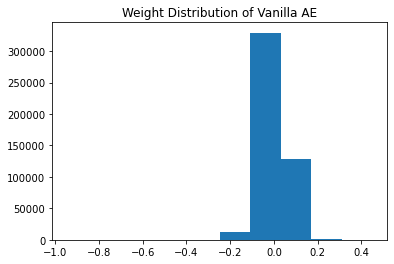

In [11]:
weight_dist(ae.get_weights(), title="Weight Distribution of Vanilla AE")

Saving figure original_digits


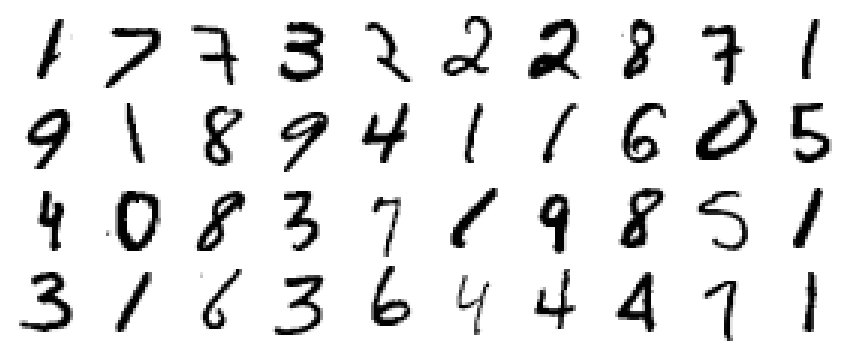

In [12]:
# visualize a few digits

digits = x_small[:40]
plt.figure(figsize=(12,12))
plot_digits(digits, images_per_row=10)
save_fig("original_digits")
plt.show()

Saving figure reconstructed_vanilla


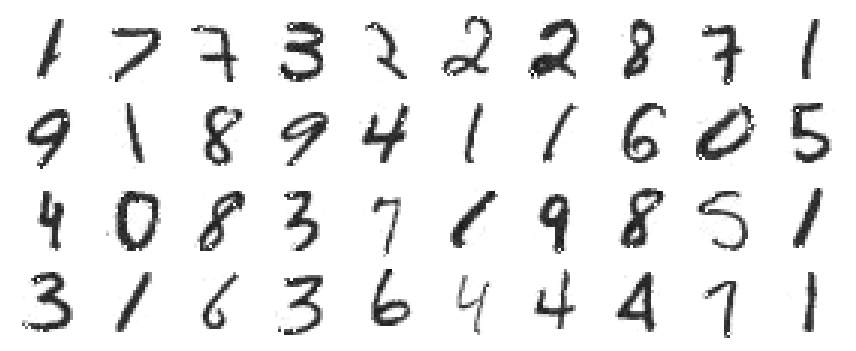

In [13]:
# feed the digits through the autoencoder and visualize the reconstructed digits

reconstructed = ae(digits)
plt.figure(figsize=(12,12))
plot_digits(reconstructed, images_per_row=10)
save_fig("reconstructed_vanilla")
plt.show()

Saving figure noisy_digits


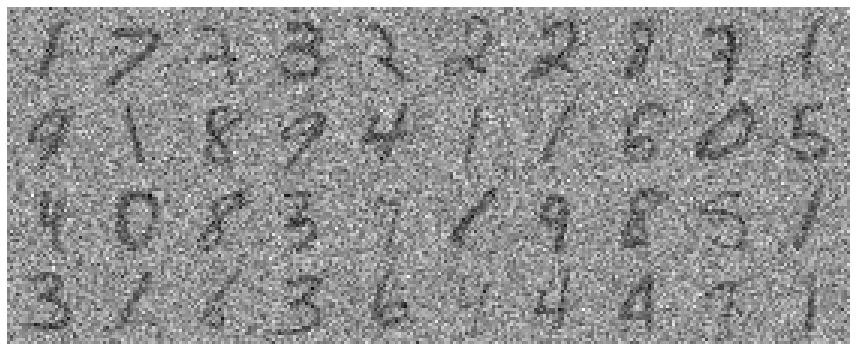

In [14]:
# add Gaussian noise to the digits and visualize the corrupted digits

noisy = add_noise(digits, stddev=0.5)
plt.figure(figsize=(12,12))
plot_digits(noisy, images_per_row=10)
save_fig("noisy_digits")
plt.show()

Saving figure denoised_vanilla


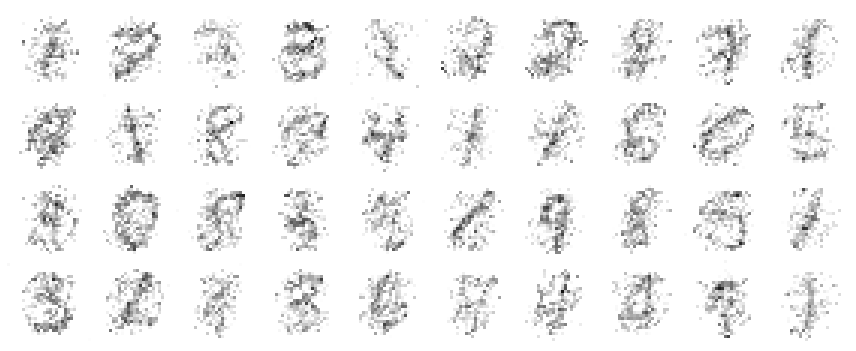

In [15]:
# use the vanilla autoencoder to denoise the corrupted digits and visualize the denoised digits

denoised = ae(noisy)
plt.figure(figsize=(12,12))
plot_digits(denoised, images_per_row=10)
save_fig("denoised_vanilla")
plt.show()

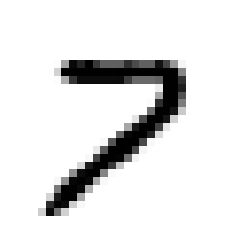

In [46]:
plt.imshow(x_small[1].reshape(28, 28, 1), cmap='binary')
plt.axis('off')
plt.show()

(-0.5, 27.5, 27.5, -0.5)

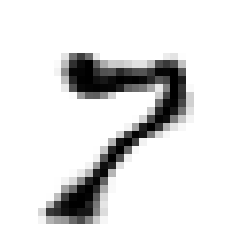

In [47]:
transformed = elastic_transform(x_small[1].reshape(28, 28, 1),8, 2)
plt.imshow(transformed, cmap='binary')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

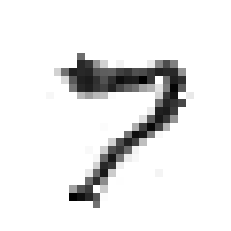

In [49]:
plt.imshow(ae.predict(transformed.reshape(1, 784)).reshape(28, 28), cmap='binary')
plt.axis('off')

In [16]:
# assess the capacity of the model to reconstruct the original digits from their corrupted version, by trying multiple times
# different noise intensities (gaussian noise)

df_input = input_robustness(x_small, ae, np.linspace(0.0, 1.0, 11), n_iter=10)

In [17]:
df_input

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.004516,0.008634,0.021080,0.039901,0.062998,0.089525,0.119411,0.152435,0.188809,0.228499,0.271949
stddev,0.000000,0.000010,0.000031,0.000051,0.000095,0.000245,0.000292,0.000385,0.000452,0.000590,0.001081


Saving figure input_robustness_vanilla


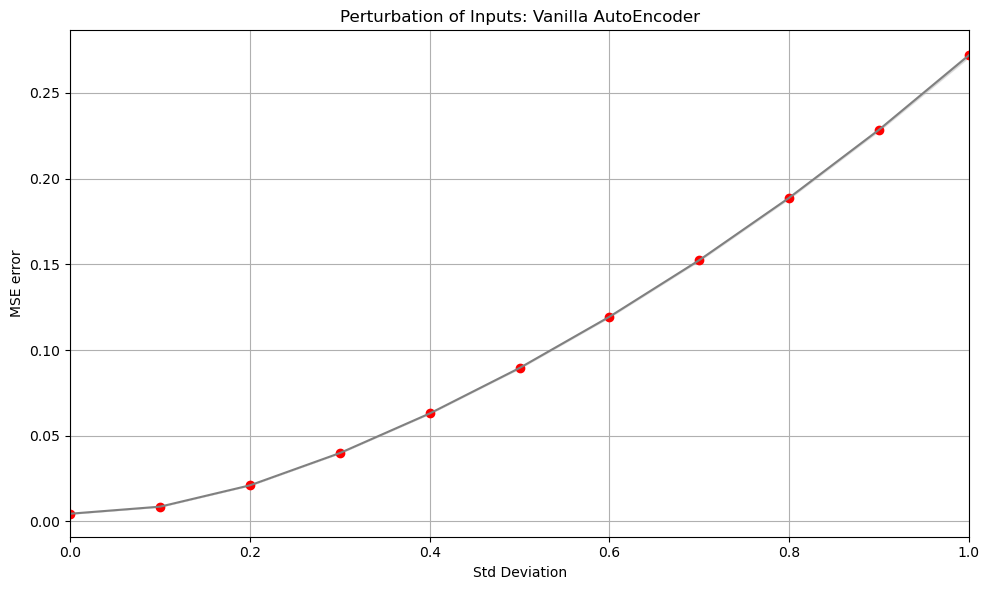

In [18]:
# plot the reconstruction error as a function of the level of corruption of the images (stddev)

plot_errors(df_input, np.linspace(0.0, 1.0, 11), title='Perturbation of Inputs: Vanilla AutoEncoder')
save_fig("input_robustness_vanilla")
plt.show()

In [19]:
# now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

df_weights = weight_robustness(x_small, x_small, ae, np.linspace(0.0, 1.0, 11), n_iter=10)

In [20]:
df_weights

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.004516,0.945493,11.657440,51.991432,163.551056,425.935852,829.228516,1609.561157,2692.236816,4225.235352,6908.224121
stddev,0.000000,0.052217,1.065418,4.662385,11.505424,39.085762,66.107788,139.597443,202.192795,369.013641,345.847443


Saving figure weight_robustness_vanilla


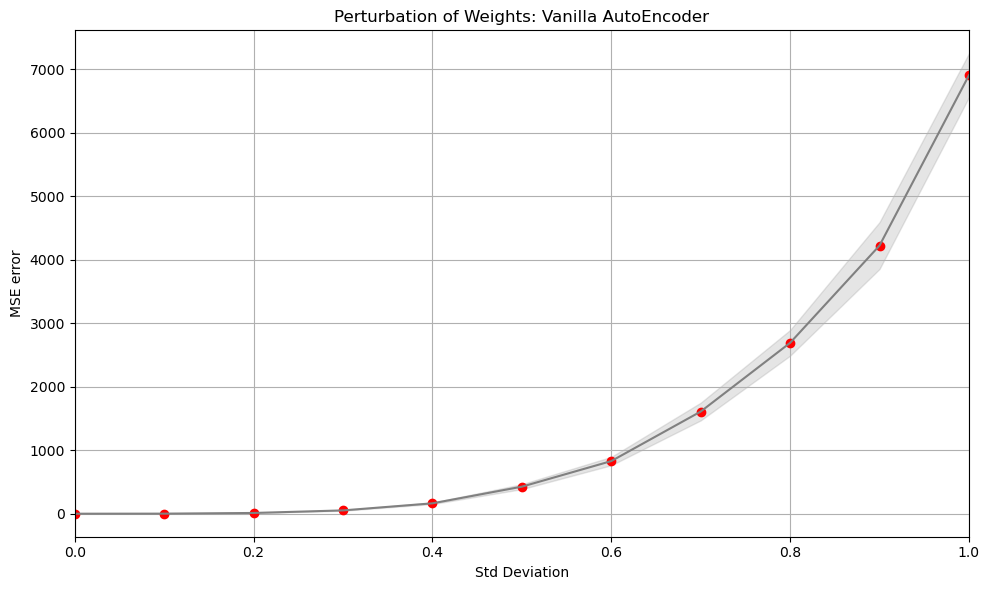

In [21]:
# plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

plot_errors(df_weights, np.linspace(0.0, 1.0, 11), title='Perturbation of Weights: Vanilla AutoEncoder')
save_fig("weight_robustness_vanilla")
plt.show()

# Denoising AE

In [50]:
# instantiate a Denoising AutoEncoder with a single hidden layer and compile it

dae = DenoisingAutoEncoder([300], [784], stddev=0.2)
dae.compile(optimizer='adam', loss='mse')

In [51]:
# set up a checkpoint callback for training

MODEL_PATH = "models/prova/denoising"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='loss',
    save_weights_only=True,
)

In [52]:
# fit on the reduced dataset

dae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0501
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 10/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 11/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 12/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 13/100


In [53]:
# use the checkpoint to load the weights of the trained model inside a newly initialized model

config = dae.get_config()

compile_config = {
    "optimizer": 'adam',
    "loss": 'mse',
}

loaded = load_model(DenoisingAutoEncoder, config, compile_config, MODEL_PATH, x_small[:1])

In [54]:
# check that the weights have been loaded correctly

assert len(dae.get_weights()) == len(loaded.get_weights())

[(loaded.get_weights()[i] == dae.get_weights()[i]).all() for i in range(len(dae.get_weights()))]


[True, True, True, True, True]

In [55]:
# check that the state of the optimizer has been restored correctly

assert len(dae.optimizer.get_weights()) == len(loaded.optimizer.get_weights())

[(loaded.optimizer.get_weights()[i] == dae.optimizer.get_weights()[i]).all() for i in range(len(dae.optimizer.get_weights()))]

[True, True, True, True, True, True, True, True, True]

Saving figure original_digits


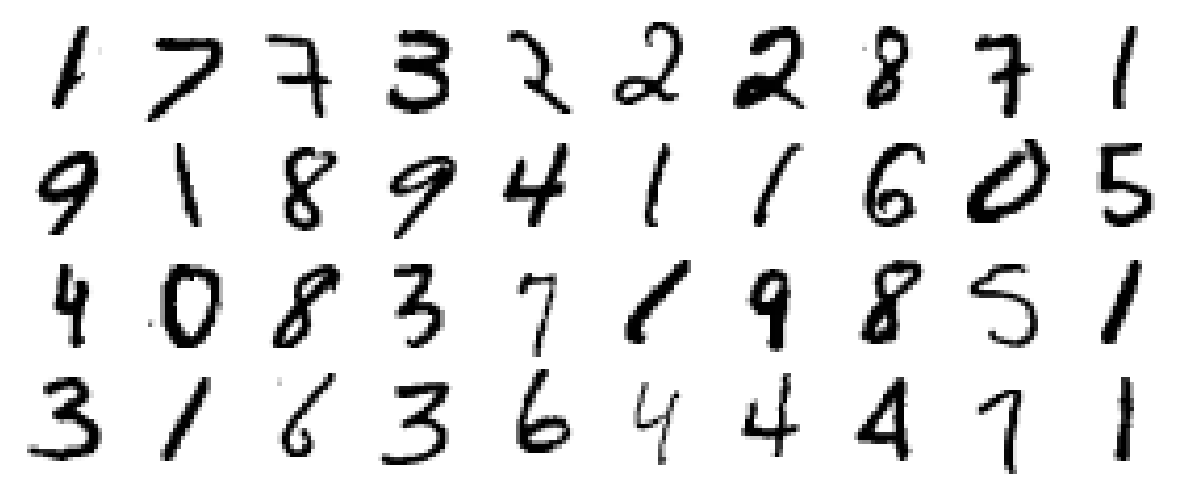

In [28]:
# visualize a few digits

digits = x_small[:40]
plt.figure(figsize=(12,12))
plot_digits(digits, images_per_row=10)
save_fig("original_digits")
plt.show()

Saving figure reconstructed_denoising


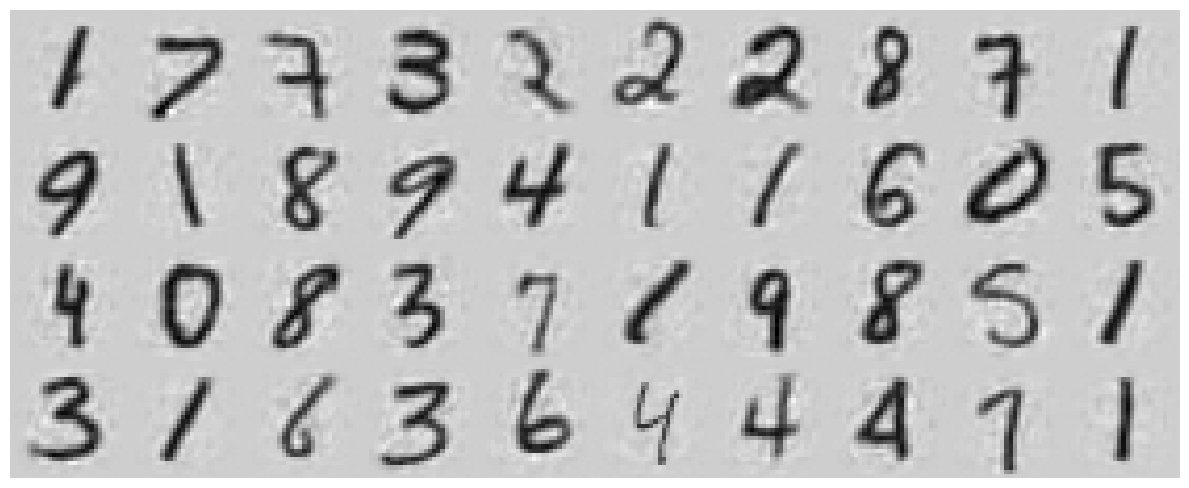

In [29]:
# feed the digits through the denoising autoencoder and visualize the reconstructed digits (noise is not applied during inference)

reconstructed = dae(digits)
plt.figure(figsize=(12,12))
plot_digits(reconstructed, images_per_row=10)
save_fig("reconstructed_denoising")
plt.show()

Saving figure noisy_digits


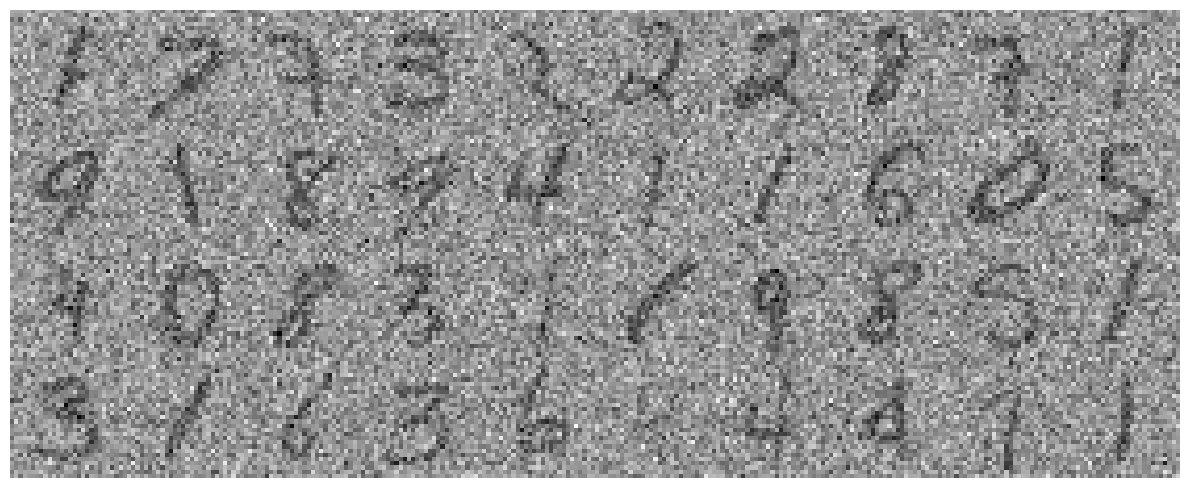

In [30]:
# add Gaussian noise to the digits and visualize the corrupted digits

noisy = add_noise(digits, stddev=0.5)
plt.figure(figsize=(12,12))
plot_digits(noisy, images_per_row=10)
save_fig("noisy_digits")
plt.show()

Saving figure denoised_denoising


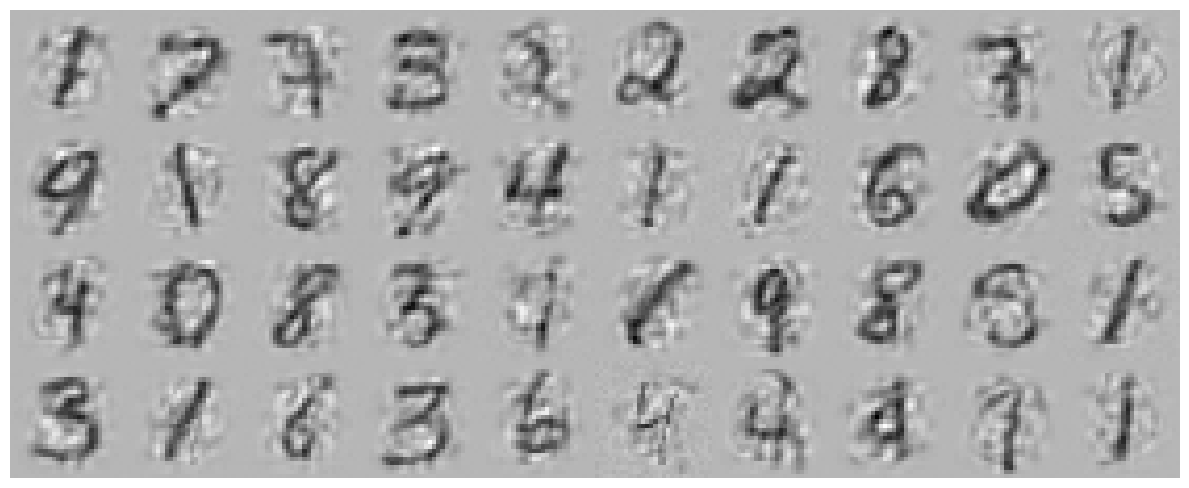

In [31]:
# use the denoising autoencoder to denoise the corrupted digits and visualize the denoised digits

denoised = dae(noisy)
plt.figure(figsize=(12,12))
plot_digits(denoised, images_per_row=10)
save_fig("denoised_denoising")
plt.show()

In [61]:
def weight_dist(weights, title='Weight Distribution'):
    """

    :param weights: weights of a Keras model.
    :param title: Title of the plot.
    :return: histogram of all weights of the model.
    """
    flat_weights = list(map(np.ndarray.flatten, weights[0:4:2]))
    # you can get the weights by layer using the list above
    # for now we plot all the weights
    all_weights = np.concatenate(flat_weights)
    print(all_weights.max())
    plt.hist(all_weights)
    plt.title(title)
    plt.show()

0.6430779


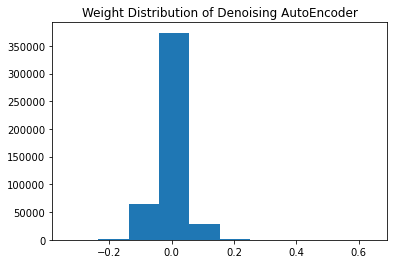

In [62]:
weight_dist(dae.get_weights(), title="Weight Distribution of Denoising AutoEncoder")

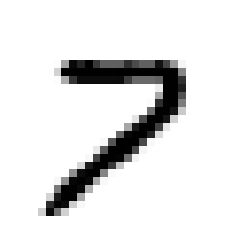

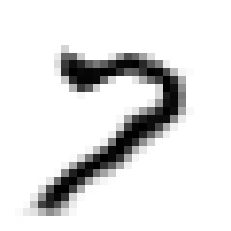

(-0.5, 27.5, 27.5, -0.5)

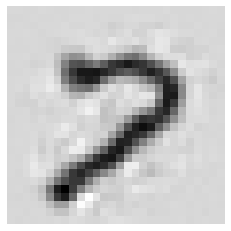

In [65]:
plt.imshow(x_small[1].reshape(28, 28, 1), cmap='binary')
plt.axis('off')
plt.show()
transformed = elastic_transform(x_small[1].reshape(28, 28, 1), 8, 2)
plt.imshow(transformed, cmap='binary')
plt.axis('off')
plt.show()
plt.axis('off')
plt.imshow(loaded.predict(transformed.reshape(1, 784)).reshape(28, 28), cmap='binary')
plt.axis('off')

In [32]:
# assess the capacity of the model to reconstruct the original digits from their corrupted version, by trying multiple times
# different noise intensities (gaussian noise)

df_input = input_robustness(x_small, dae, np.linspace(0.0, 1.0, 11), n_iter=10)

In [33]:
df_input

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.005983,0.006777,0.009153,0.013074,0.018606,0.025751,0.034692,0.045758,0.059235,0.075591,0.095199
stddev,0.000000,0.000003,0.000012,0.000019,0.000028,0.000050,0.000064,0.000088,0.000099,0.000132,0.000272


In [34]:
# sanity check

df_input.iloc[0, 0] == dae.evaluate(x_small, x_small)

157/157 [==============================] - 0s 805us/step - loss: 0.0060


True

Saving figure input_robustness_denoising


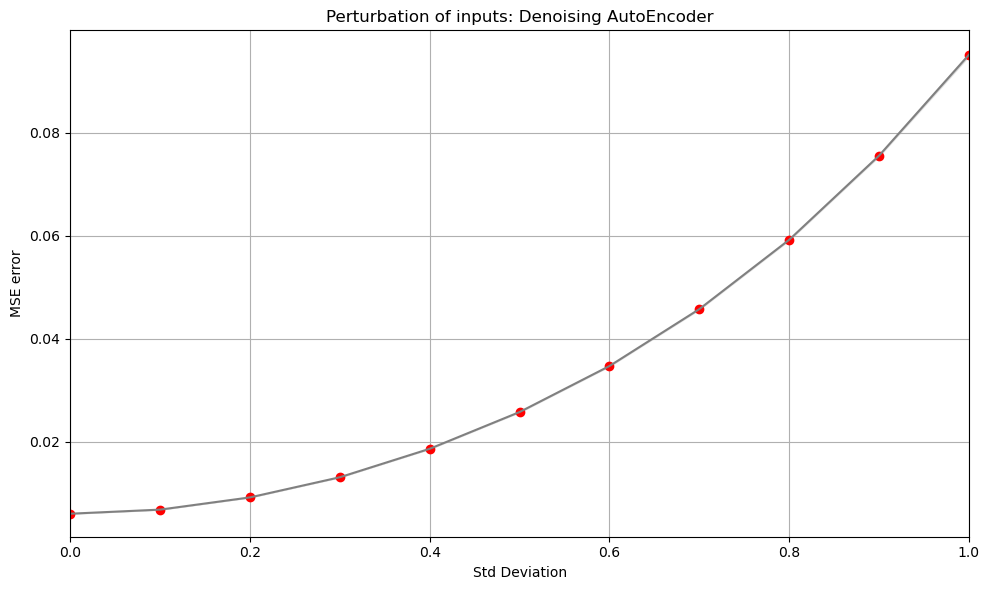

In [35]:
# plot the reconstruction error as a function of the level of corruption of the images (stddev)

plot_errors(df_input, np.linspace(0.0, 1.0, 11), title='Perturbation of inputs: Denoising AutoEncoder')
save_fig("input_robustness_denoising")
plt.show()

In [36]:
# now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

df_weights = weight_robustness(x_small, x_small, dae, np.linspace(0.0, 1.0, 11), n_iter=10)

In [37]:
df_weights

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.005983,1.722335,16.814814,77.301170,245.605057,602.905640,1321.238647,2623.427734,4175.912598,7255.454102,11147.310547
stddev,0.000000,0.130833,0.907750,5.426152,22.013523,25.336996,151.397415,153.896988,458.076172,428.562195,782.112427


Saving figure weight_robustness_denoising


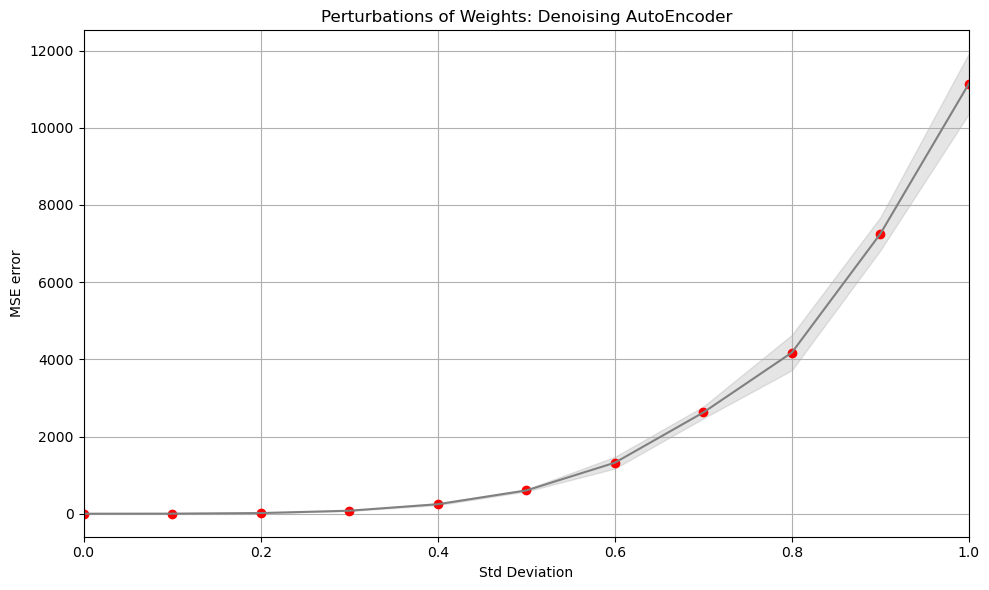

In [38]:
# plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

plot_errors(df_weights, np.linspace(0.0, 1.0, 11), title='Perturbations of Weights: Denoising AutoEncoder')
save_fig("weight_robustness_denoising")
plt.show()

# Replicated AE

Started (2e-05, 0.1)


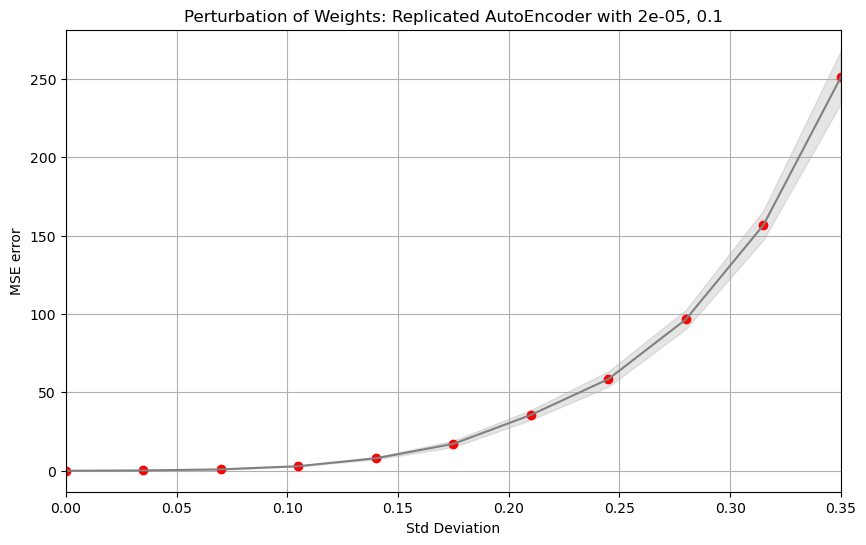

Started (2e-05, 0.2)


KeyboardInterrupt: 

In [10]:
# big for loop

for gamma, coef in [(2e-5, 0.1), (2e-5, 0.2), (1e-4, 0.2)]:

    print(f'Started {gamma, coef}')
    # instantiate a Replicated AutoEncoder with a single hidden layer and compile it
    rae = ReplicatedAutoEncoder([300], [784], n_replicas=100)
    rae.compile(optimizer='adam', loss='mse')

    # set up a checkpoint callback for training

    MODEL_PATH = "models/prova/replicated"

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='loss',
        save_weights_only=True,
    )

    # set up a callback to schedule the regularization rate during training
    rate_callback = ExponentialRateCallback(gamma, coef, verbose=0)
    rae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback, rate_callback], verbose=0)

    # use the checkpoint to load the weights of the trained model inside a newly initialized model

    config = rae.get_config()

    compile_config = {
        "optimizer": 'adam',
        "loss": 'mse',
    }

    loaded = load_model(ReplicatedAutoEncoder, config, compile_config, MODEL_PATH, x_small[:1])

    # now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

    df_weights = weight_robustness(x_small, x_small, rae, np.linspace(0.0, 0.35, 11), n_iter=10)

    # plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

    plot_errors(df_weights, np.linspace(0.0, 0.35, 11), title=f'Perturbation of Weights: Replicated AutoEncoder with {gamma}, {coef}')
    plt.show()

In [21]:
# set up a checkpoint callback for training

MODEL_PATH = "models/prova/replicated"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='loss',
    save_weights_only=True,
)

In [22]:
# set up a callback to schedule the regularization rate during training

rate_callback = ExponentialRateCallback(1e-7, 0.1)

In [23]:
# fit on the reduced dataset

rae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback, rate_callback])


Setting rate to 1.0000000116860974e-07 

Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 0.0795 - reconstruction_loss: 0.0795 - distance_loss: 864.3820

Setting rate to 1.1000000199601345e-07 

Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0532 - reconstruction_loss: 0.0531 - distance_loss: 850.7169

Setting rate to 1.2099999935344385e-07 

Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0400 - reconstruction_loss: 0.0399 - distance_loss: 830.4354

Setting rate to 1.3310000213095918e-07 

Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0319 - reconstruction_loss: 0.0318 - distance_loss: 804.6229

Setting rate to 1.464100023440551e-07 

Epoch 5/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0262 - reconstruction_loss: 0.0261 - distance_loss: 774.4601

Setting rate to 1.6105100542063155e-07 

Epoch 6/100
32/32 [==============================] - 1s 29ms/ste

In [24]:
# use the checkpoint to load the weights of the trained model inside a newly initialized model

config = rae.get_config()

compile_config = {
    "optimizer": 'adam',
    "loss": 'mse',
}

loaded = load_model(ReplicatedAutoEncoder, config, compile_config, MODEL_PATH, x_small[:1])

In [25]:
# check that the weights have been loaded correctly

assert len(rae.get_weights()) == len(loaded.get_weights())

[(loaded.get_weights()[i] == rae.get_weights()[i]).all() for i in range(len(rae.get_weights()))]


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [26]:
# check that the state of the optimizer has been restored correctly

assert len(rae.optimizer.get_weights()) == len(loaded.optimizer.get_weights())

[(loaded.optimizer.get_weights()[i] == rae.optimizer.get_weights()[i]).all() for i in range(len(rae.optimizer.get_weights()))]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [36]:
# assess the capacity of the model to reconstruct the original digits from their corrupted version, by trying multiple times
# different noise intensities (gaussian noise)

df_input = input_robustness(x_small, rae, np.linspace(0.0, 1.0, 11), n_iter=10)

In [37]:
df_input

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.002073,0.004864,0.012426,0.02416,0.039745,0.058785,0.083197,0.105197,0.135929,0.170393,0.205211
stddev,0.000000,0.000092,0.000254,0.00065,0.001271,0.001825,0.003590,0.004477,0.006227,0.006895,0.011257


In [38]:
# sanity check

df_input.iloc[0, 0] == rae.evaluate(x_small, x_small)

32/32 [==============================] - 0s 3ms/step - baricenter: 0.0021


True

Saving figure input_robustness_replicated


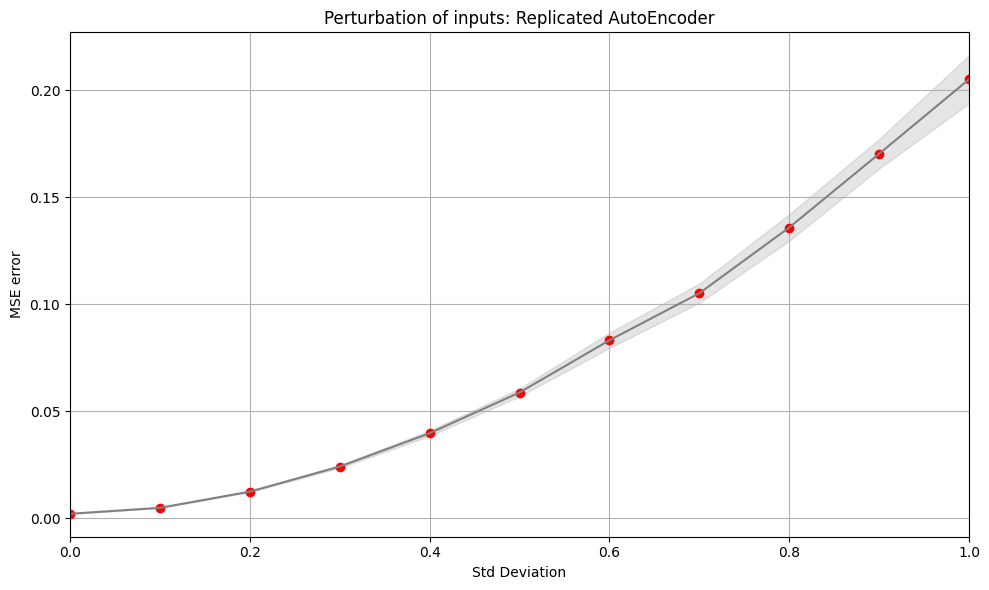

In [40]:
# plot the reconstruction error as a function of the level of corruption of the images (stddev)

plot_errors(df_input, np.linspace(0.0, 1.0, 11), title='Perturbation of inputs: Replicated AutoEncoder')
save_fig("input_robustness_replicated")
plt.show()

In [41]:
# now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

df_weights = weight_robustness(x_small, x_small, rae, np.linspace(0.0, 1.0, 11), n_iter=10)

In [42]:
df_weights

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.002073,2.925468,30.557089,132.955719,407.810730,1019.341003,1911.265991,3537.578125,6354.881836,9413.379883,14500.302734
stddev,0.000000,0.241589,2.466689,10.879687,35.276436,76.357841,200.549545,162.365921,472.150726,838.129517,886.590271


Saving figure weight_robustness_replicated


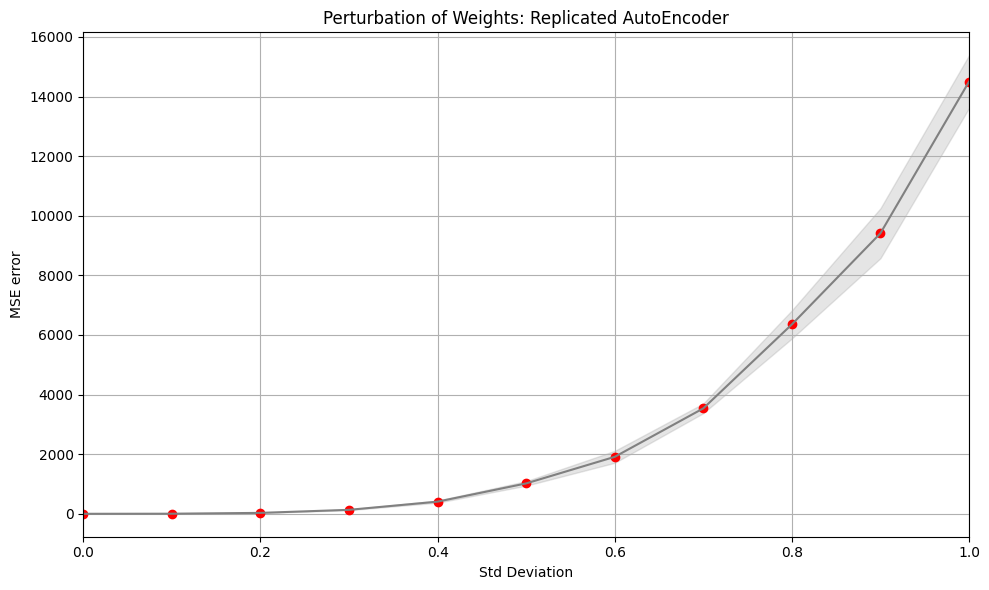

In [43]:
# plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

plot_errors(df_weights, np.linspace(0.0, 1.0, 11), title='Perturbation of Weights: Replicated AutoEncoder')
save_fig("weight_robustness_replicated")
plt.show()

In [ ]:
# big for loop


# Overnight Tests

In [13]:
# subsample the data to speed up computations

SAMPLE_SIZE = 30000
x_small = subsample(x_train, SAMPLE_SIZE, stratify=y_train)

Started (1e-06, 0.1)
Epoch 1/100
938/938 [==============================] - 24s 24ms/step - loss: 0.0187 - reconstruction_loss: 0.0183 - distance_loss: 362.2359
Epoch 2/100
938/938 [==============================] - 26s 28ms/step - loss: 0.0067 - reconstruction_loss: 0.0065 - distance_loss: 141.6110
Epoch 3/100
938/938 [==============================] - 27s 28ms/step - loss: 0.0053 - reconstruction_loss: 0.0052 - distance_loss: 66.6123
Epoch 4/100
938/938 [==============================] - 27s 29ms/step - loss: 0.0046 - reconstruction_loss: 0.0046 - distance_loss: 34.7232
Epoch 5/100
938/938 [==============================] - 27s 29ms/step - loss: 0.0043 - reconstruction_loss: 0.0042 - distance_loss: 20.2040
Epoch 6/100
938/938 [==============================] - 27s 29ms/step - loss: 0.0040 - reconstruction_loss: 0.0040 - distance_loss: 13.6908
Epoch 7/100
938/938 [==============================] - 27s 29ms/step - loss: 0.0038 - reconstruction_loss: 0.0038 - distance_loss: 10.7900
Epoc

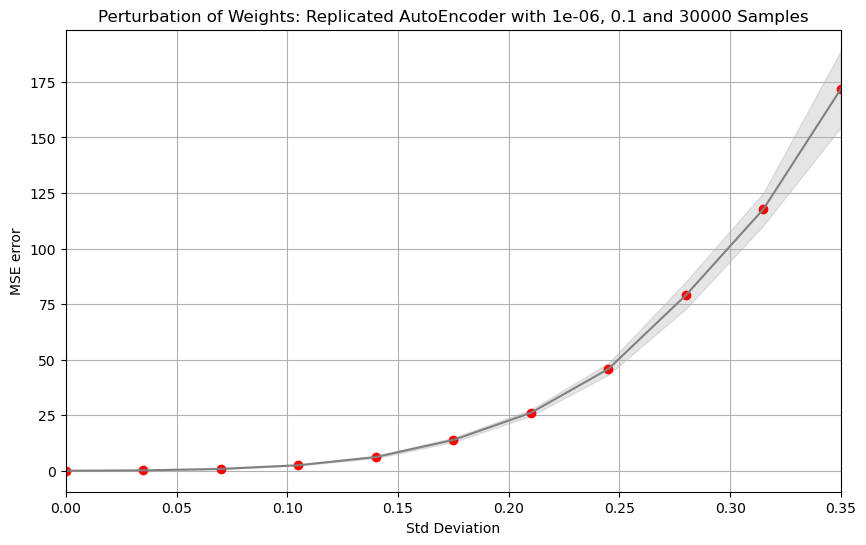

In [15]:
# big for loop

for gamma, coef in [(1e-6, 0.1)]:
    print(f'Started {gamma, coef}')
    # instantiate a Replicated AutoEncoder with a single hidden layer and compile it
    rae = ReplicatedAutoEncoder([300], [784], n_replicas=20)
    rae.compile(optimizer='adam', loss='mse')

    # set up a checkpoint callback for training

    MODEL_PATH = "models/prova/replicated"

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='loss',
        save_weights_only=True,
    )

    # set up a callback to schedule the regularization rate during training
    rate_callback = ExponentialRateCallback(gamma, coef, verbose=0)
    rae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback, rate_callback])

    # use the checkpoint to load the weights of the trained model inside a newly initialized model

    config = rae.get_config()

    compile_config = {
        "optimizer": 'adam',
        "loss": 'mse',
    }

    loaded = load_model(ReplicatedAutoEncoder, config, compile_config, MODEL_PATH, x_small[:1])

    # now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

    df_weights = weight_robustness(x_small, x_small, rae, np.linspace(0.0, 0.35, 11), n_iter=10)

    # plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

    plot_errors(df_weights, np.linspace(0.0, 0.35, 11),
                title=f'Perturbation of Weights: Replicated AutoEncoder with {gamma}, {coef} and 30000 Samples')
    plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_110 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_111 (Dense)            (None, 784)               235984    
Total params: 471,484
Trainable params: 471,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0127
Epoch 2/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 4/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 5/100
938/938 [==============================] - 2s

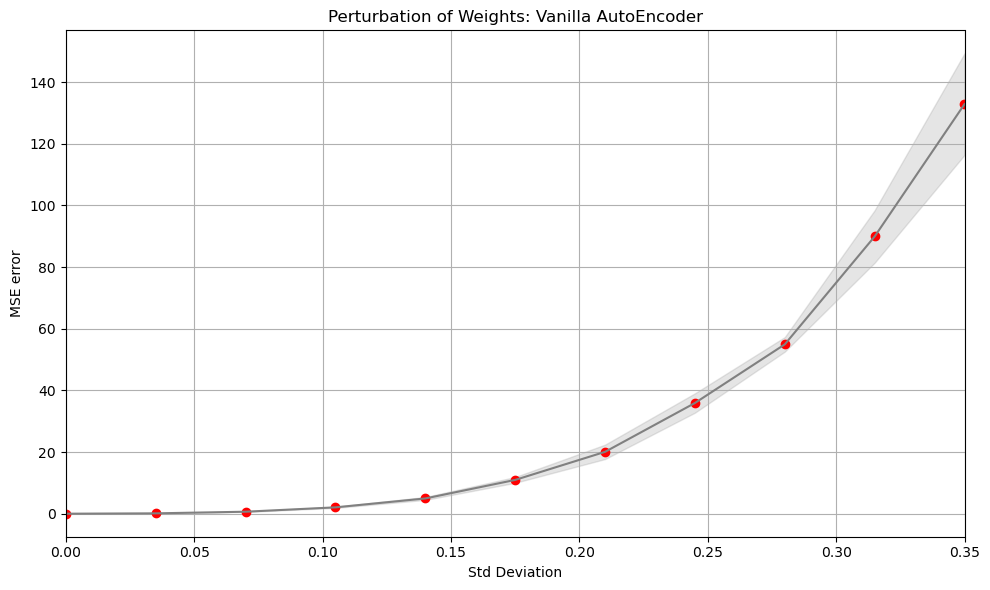

In [16]:
# instantiate a simple AutoEncoder with a single hidden layer and compile it

ae = build_ae([300, 784], reg_lambda=1e-6)
ae.compile(optimizer='adam', loss='mse')
ae.summary()
# set up a checkpoint callback for training

MODEL_PATH = "vanilla.h5"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='loss',
    save_best_only=True,
)
# fit on the reduced dataset

ae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback])
# now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

df_weights = weight_robustness(x_small, x_small, ae, np.linspace(0.0, 0.35, 11), n_iter=10)
# plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

plot_errors(df_weights, np.linspace(0.0, 0.35, 11), title='Perturbation of Weights: Vanilla AutoEncoder')
save_fig("weight_robustness_vanilla")
plt.show()


In [17]:
# subsample the data to speed up computations

SAMPLE_SIZE = 60000
x_small = subsample(x_train, SAMPLE_SIZE, stratify=y_train)

ValueError: train_size=60000 should be either positive and smaller than the number of samples 60000 or a float in the (0, 1) range

In [ ]:
# big for loop

for gamma, coef in [(1e-6, 0.1)]:
    print(f'Started {gamma, coef}')
    # instantiate a Replicated AutoEncoder with a single hidden layer and compile it
    rae = ReplicatedAutoEncoder([100], [784], n_replicas=50)
    rae.compile(optimizer='adam', loss='mse')

    # set up a checkpoint callback for training

    MODEL_PATH = "models/prova/replicated"

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='loss',
        save_weights_only=True,
    )

    # set up a callback to schedule the regularization rate during training
    rate_callback = ExponentialRateCallback(gamma, coef, verbose=0)
    rae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback, rate_callback], verbose=0)

    # use the checkpoint to load the weights of the trained model inside a newly initialized model

    config = rae.get_config()

    compile_config = {
        "optimizer": 'adam',
        "loss": 'mse',
    }

    loaded = load_model(ReplicatedAutoEncoder, config, compile_config, MODEL_PATH, x_small[:1])

    # now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

    df_weights = weight_robustness(x_small, x_small, rae, np.linspace(0.0, 0.35, 11), n_iter=10)

    # plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

    plot_errors(df_weights, np.linspace(0.0, 0.35, 11),
                title=f'Perturbation of Weights: Replicated AutoEncoder with {gamma}, {coef}')
    plt.show()

In [ ]:
# instantiate a simple AutoEncoder with a single hidden layer and compile it

ae = build_ae([100, 784], reg_lambda=1e-6)
ae.compile(optimizer='adam', loss='mse')
ae.summary()
# set up a checkpoint callback for training

MODEL_PATH = "vanilla.h5"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='loss',
    save_best_only=True,
)
# fit on the reduced dataset

ae.fit(x_small, x_small, epochs=100, callbacks=[checkpoint_callback])
# now perturb weights and see how this affects the capacity of the model to reconstruct (non-noisy) images

df_weights = weight_robustness(x_small, x_small, ae, np.linspace(0.0, 0.35, 11), n_iter=10)
# plot the reconstruction error as a function of the degree of perturbation of the weights (stddev)

plot_errors(df_weights, np.linspace(0.0, 0.35, 11), title='Perturbation of Weights: Vanilla AutoEncoder')
save_fig("weight_robustness_vanilla")
plt.show()